In [1]:
import pandas as pd
import numpy as np
import requests as re
import lxml.html as lh
from datetime import datetime, date, timedelta, time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier

In [2]:
sns.set_theme(style="darkgrid")
new_style = {'grid': False}
plt.rc('axes', **new_style)

## Variables

In [5]:
nombre_meses = {
    1: 'enero',
    2: 'febrero',
    3: 'marzo',
    4: 'abril',
    5: 'mayo',
    6: 'junio',
    7: 'julio',
    8: 'agosto',
    9: 'septiembre',
    10: 'octubre',
    11: 'noviembre',
    12: 'diciembre'    
}
meses = list(nombre_meses.values())
meses = [m[:3] for m in meses]

In [6]:
dias_semana = ['lunes','martes','miércoles','jueves','viernes','sábado','domingo']

## Carga de datos

![alternative text](data/problema.png)

In [33]:
df = pd.read_csv('data/dataset_SCL.csv')
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'], format='%Y-%m-%d %H:%M:%S')
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'], format='%Y-%m-%d %H:%M:%S')
df['Fecha-I-5'] = df['Fecha-I'].dt.ceil(freq='5T')
df['fecha_programada'] = df['Fecha-I'].dt.date
df['dia_semana'] = df['Fecha-I'].dt.weekday
df['hora'] = df['Fecha-I-5'].dt.hour
df['minutos'] = df['Fecha-I-5'].dt.minute
df.head()

C:\Users\hernan.valenzuela.q\AppData\Local\Temp\ipykernel_7656\1246897437.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/dataset_SCL.csv')


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,Fecha-I-5,fecha_programada,dia_semana,hora,minutos
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,Domingo,I,American Airlines,Santiago,Miami,2017-01-01 23:30:00,2017-01-01,6,23,30
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,Lunes,I,American Airlines,Santiago,Miami,2017-01-02 23:30:00,2017-01-02,0,23,30
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,Martes,I,American Airlines,Santiago,Miami,2017-01-03 23:30:00,2017-01-03,1,23,30
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,Miercoles,I,American Airlines,Santiago,Miami,2017-01-04 23:30:00,2017-01-04,2,23,30
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,Jueves,I,American Airlines,Santiago,Miami,2017-01-05 23:30:00,2017-01-05,3,23,30


In [9]:
df.dtypes

Fecha-I       datetime64[ns]
Vlo-I                 object
Ori-I                 object
Des-I                 object
Emp-I                 object
Fecha-O       datetime64[ns]
Vlo-O                 object
Ori-O                 object
Des-O                 object
Emp-O                 object
DIA                    int64
MES                    int64
AÑO                    int64
DIANOM                object
TIPOVUELO             object
OPERA                 object
SIGLAORI              object
SIGLADES              object
Fecha-I-5     datetime64[ns]
dia_semana             int64
hora                   int64
minutos                int64
dtype: object

![alternative text](data/desafio.png)

## Distribución de los datos

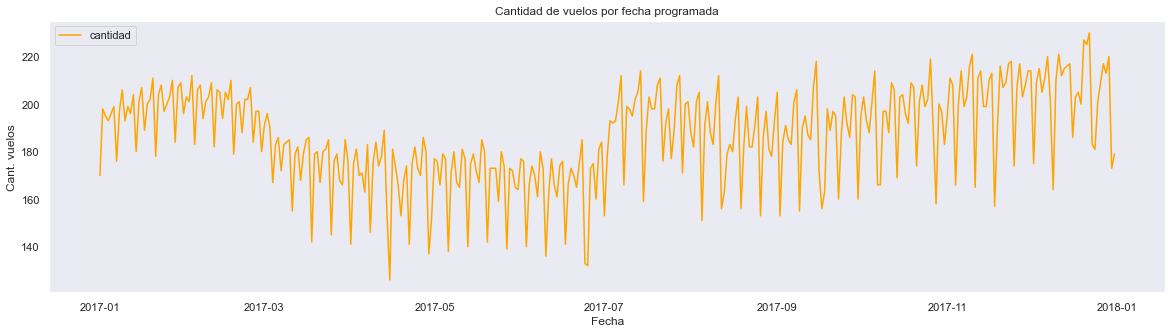

In [40]:
agg = df.groupby('fecha_programada')['Vlo-I'].count().to_frame()
agg.rename(columns={'Vlo-I':'cantidad'}, inplace=True)

fig, ax1 = plt.subplots(1,1,figsize=(20, 5))
agg.plot(kind='line', ax=ax1, rot=0, color='orange')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Cant. vuelos')
ax1.set_title('Cantidad de vuelos por fecha programada')
plt.show()

###  - Distribución a nivel de meses

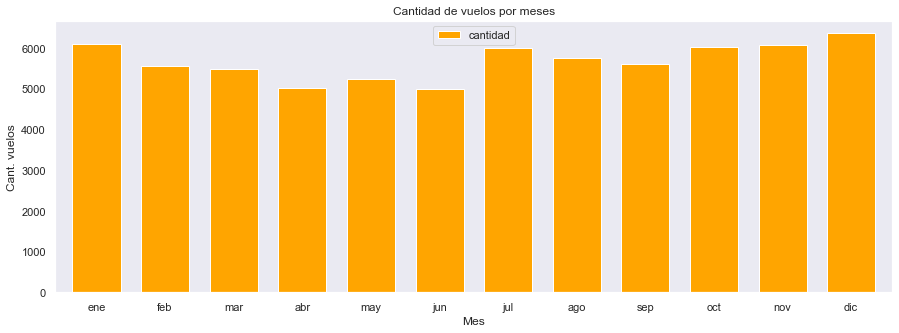

In [20]:
agg = df.groupby('MES')['Vlo-I'].count().to_frame()
agg.rename(columns={'Vlo-I':'cantidad'}, inplace=True)

fig, ax1 = plt.subplots(1,1,figsize=(15, 5))
agg.plot(kind='bar', ax=ax1, rot=0, color='orange', width=0.7)
ax1.set_xticklabels(meses)
ax1.set_xlabel('Mes')
ax1.set_ylabel('Cant. vuelos')
ax1.set_title('Cantidad de vuelos por meses')
plt.show()

###  - Distribución a nivel de días de semana

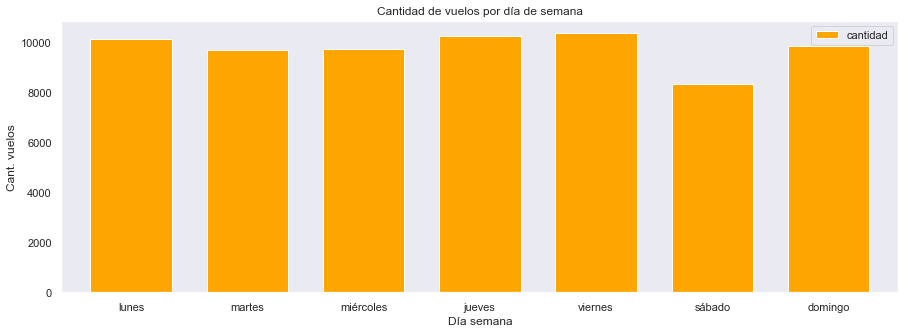

In [21]:
agg = df.groupby('dia_semana')['Vlo-I'].count().to_frame()
agg.rename(columns={'Vlo-I':'cantidad'}, inplace=True)

fig, ax1 = plt.subplots(1,1,figsize=(15, 5))
agg.plot(kind='bar', ax=ax1, rot=0, color='orange', width=0.7)
ax1.set_xticklabels(dias_semana)
ax1.set_xlabel('Día semana')
ax1.set_ylabel('Cant. vuelos')
ax1.set_title('Cantidad de vuelos por día de semana')
plt.show()

###  - Distribución a nivel de hora

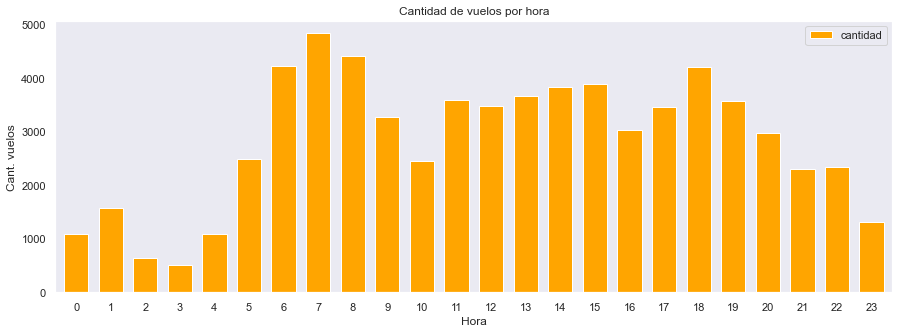

In [27]:
agg = df.groupby('hora')['Vlo-I'].count().to_frame()
agg.rename(columns={'Vlo-I':'cantidad'}, inplace=True)

fig, ax1 = plt.subplots(1,1,figsize=(15, 5))
agg.plot(kind='bar', ax=ax1, rot=0, color='orange', width=0.7)
ax1.set_xlabel('Hora')
ax1.set_ylabel('Cant. vuelos')
ax1.set_title('Cantidad de vuelos por hora')
plt.show()

###  - Distribución a nivel de operadores

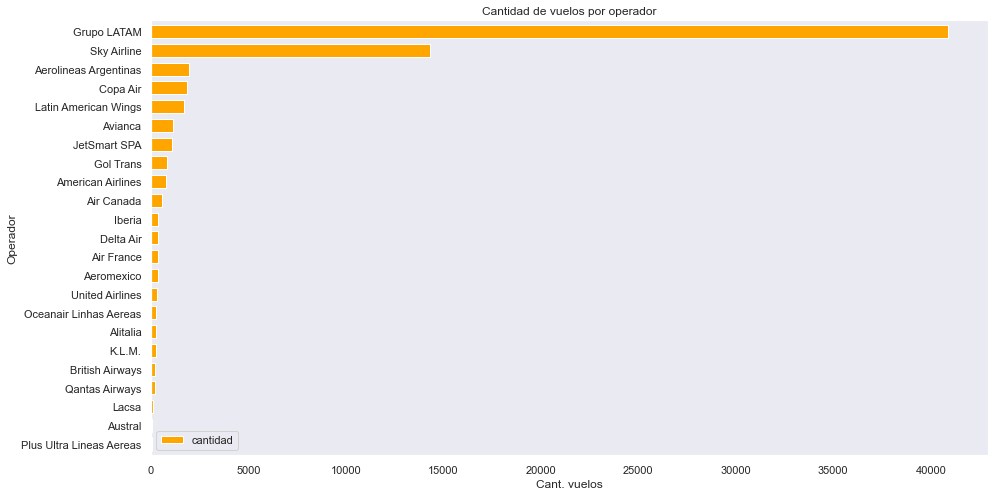

In [31]:
agg = df.groupby('OPERA')['Vlo-I'].count().to_frame()
agg.rename(columns={'Vlo-I':'cantidad'}, inplace=True)
agg.sort_values(by='cantidad', ascending=True, inplace=True)

fig, ax1 = plt.subplots(1,1,figsize=(15, 8))
agg.plot(kind='barh', ax=ax1, rot=0, color='orange', width=0.7)
ax1.set_ylabel('Operador')
ax1.set_xlabel('Cant. vuelos')
ax1.set_title('Cantidad de vuelos por operador')
plt.show()

###  - Distribución a nivel de destinos

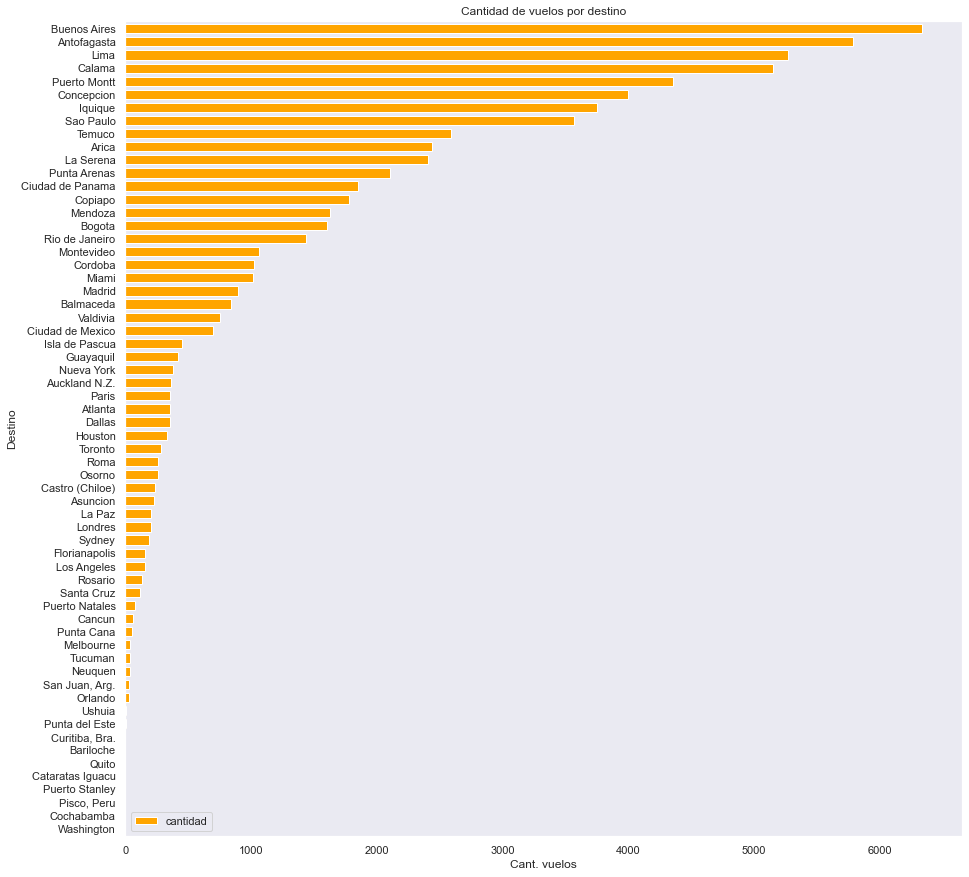

In [32]:
agg = df.groupby('SIGLADES')['Vlo-I'].count().to_frame()
agg.rename(columns={'Vlo-I':'cantidad'}, inplace=True)
agg.sort_values(by='cantidad', ascending=True, inplace=True)

fig, ax1 = plt.subplots(1,1,figsize=(15, 15))
agg.plot(kind='barh', ax=ax1, rot=0, color='orange', width=0.7)
ax1.set_ylabel('Destino')
ax1.set_xlabel('Cant. vuelos')
ax1.set_title('Cantidad de vuelos por destino')
plt.show()

<font size=3>A nivel general se aprecia que los datos presentan determinado patrón en su comportamiento y que se mantiene en el tiempo solo modificando su magnitud, en cuanto a su apertura a nivel de variables temporales se puede observar que a nivel de meses y días la cantidad de vuelos se distribuye de manera equilibrada, en cuanto a la apertura a nivel de hora apreciamos que existen horarios que tienen una menor cantidad de vuelos comparada a otros horarios.</font>

<font size=3>También podemos visualizar que a nivel de operador y destinos tenemos un desequilibrio en los datos dado que existen valores que concentran una mayor cantidad de vuelos comparados al resto, lo que podría ser un problema al momento de generar un modelo dada su generalización.</font>

## Generación de variables adicionales

In [41]:
def obtener_temporada(fecha):
    año = fecha.year
    fecha1 = datetime(año - 1, 12, 15) + timedelta(days=17)
    fecha2 = datetime(año, 3, 3) + timedelta(days=17)
    fecha3 = datetime(año, 7, 15)
    fecha4 = datetime(año, 7, 31)
    fecha5 = datetime(año, 9, 11)
    fecha6 = datetime(año, 9, 30)   
    if ((fecha + timedelta(days=17)) >= fecha1) & ((fecha + timedelta(days=17)) <= fecha2):
        temporada_alta = 1
    elif (fecha >= fecha3) & (fecha <= fecha4):
        temporada_alta = 1
    elif (fecha >= fecha5) & (fecha <= fecha6):
        temporada_alta = 1
    else:
        temporada_alta = 0
    
    return temporada_alta

In [42]:
def obtener_periodo(fecha):
    tiempo = fecha.time()
    if (tiempo >= time(5, 0)) & (tiempo <= time(11, 59)):
        return 'Mañana'
    elif (tiempo >= time(12, 0)) & (tiempo <= time(18, 59)):
        return 'Tarde'
    else:
        return 'Noche'

In [43]:
df['temporada_alta'] = df['Fecha-I'].apply(lambda x: obtener_temporada(x))
df['dif_min'] = (df['Fecha-O'] - df['Fecha-I']) / pd.Timedelta(minutes=1)
df['atraso_15'] = (df.dif_min > 15) * 1
df['periodo_dia'] = df['Fecha-I'].apply(lambda x: obtener_periodo(x))
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,SIGLADES,Fecha-I-5,fecha_programada,dia_semana,hora,minutos,temporada_alta,dif_min,atraso_15,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,Miami,2017-01-01 23:30:00,2017-01-01,6,23,30,1,3.0,0,Noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,Miami,2017-01-02 23:30:00,2017-01-02,0,23,30,1,9.0,0,Noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,Miami,2017-01-03 23:30:00,2017-01-03,1,23,30,1,9.0,0,Noche
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,Miami,2017-01-04 23:30:00,2017-01-04,2,23,30,1,3.0,0,Noche
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,Miami,2017-01-05 23:30:00,2017-01-05,3,23,30,1,-2.0,0,Noche


In [44]:
df[['temporada_alta','dif_min','atraso_15','periodo_dia']].to_csv('synthetic_features.csv')